<a href="https://www.kaggle.com/code/maimunulkjisan/leafguardnet-lightweight-cnn-for-rice-disease?scriptVersionId=235837572" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Data acquisition and Augmentaion**

In [2]:
Input_Image = 256
Channels = 3
batch_size = 32
EPOCHS = 10


# Data augmentation for training set
train_data = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

# Training set
train_set = train_data.flow_from_directory(
    "/kaggle/input/rice-leaf-datasettrain-test-and-valid/train",
    target_size=(Input_Image, Input_Image),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True
)

# Validation and test sets
common_data = ImageDataGenerator(rescale=1./255)

test_set = common_data.flow_from_directory(
    "/kaggle/input/rice-leaf-datasettrain-test-and-valid/test",
    target_size=(Input_Image, Input_Image),
    batch_size=batch_size,
    class_mode='categorical'
)

val_set = common_data.flow_from_directory(
    "/kaggle/input/rice-leaf-datasettrain-test-and-valid/val",
    target_size=(Input_Image, Input_Image),
    batch_size=batch_size,
    class_mode='categorical'
)
# Input shape
input_shape = (Input_Image, Input_Image, Channels)

Found 4745 images belonging to 4 classes.
Found 595 images belonging to 4 classes.
Found 592 images belonging to 4 classes.


In [3]:
for image_batch, label_batch in train_set:
    print(image_batch.shape)
    break

(32, 256, 256, 3)


In [4]:
class_names=['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']
print(class_names)

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


# **CNN Model Architecture**

In [5]:
cnn= models.Sequential([
    layers.InputLayer(input_shape= input_shape),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(4, activation='softmax')
])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [6]:
cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [7]:
history=cnn.fit(
    train_set,
    steps_per_epoch=148,
    batch_size=32,
    validation_data= val_set,
    epochs=20
)

Epoch 1/20
148/148 [==============================] - 374s 3s/step - loss: 1.1686 - accuracy: 0.4706 - val_loss: 0.9447 - val_accuracy: 0.6402
Epoch 2/20
148/148 [==============================] - 361s 2s/step - loss: 0.7417 - accuracy: 0.7230 - val_loss: 0.7982 - val_accuracy: 0.6943
Epoch 3/20
148/148 [==============================] - 367s 2s/step - loss: 0.6232 - accuracy: 0.7581 - val_loss: 0.5687 - val_accuracy: 0.7720
Epoch 4/20
148/148 [==============================] - 367s 2s/step - loss: 0.4836 - accuracy: 0.8148 - val_loss: 0.4386 - val_accuracy: 0.8024
Epoch 5/20
148/148 [==============================] - 358s 2s/step - loss: 0.3945 - accuracy: 0.8468 - val_loss: 0.3883 - val_accuracy: 0.8226
Epoch 6/20
148/148 [==============================] - 358s 2s/step - loss: 0.3716 - accuracy: 0.8612 - val_loss: 0.3526 - val_accuracy: 0.8497
Epoch 7/20
148/148 [==============================] - 358s 2s/step - loss: 0.3017 - accuracy: 0.8882 - val_loss: 0.2594 - val_accuracy: 0.9071

In [8]:
scores= cnn.evaluate(test_set)

19/19 [==============================] - 14s 712ms/step - loss: 0.0348 - accuracy: 0.9916


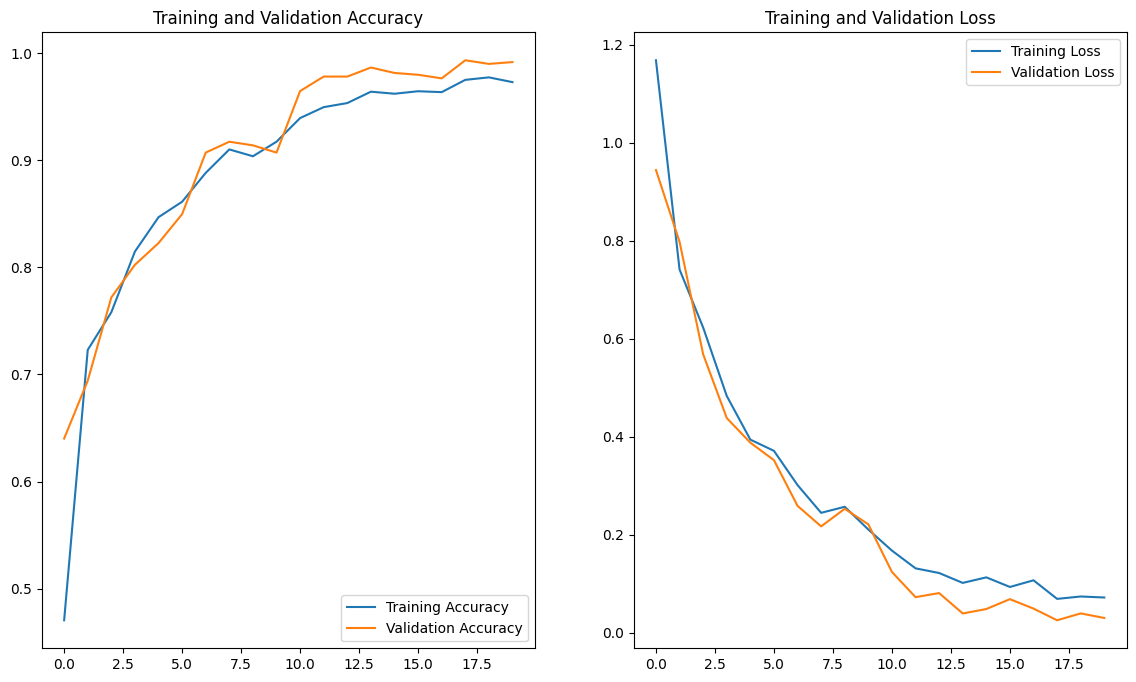

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS=20
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def extract_data(generator):
    data_list = []
    labels_list = []
    for _ in range(generator.__len__()):
        data, labels = generator.next()
        data_list.append(data)
        labels_list.append(labels)
    x = np.vstack(data_list)
    y = np.vstack(labels_list)
    return x, y

x_train, y_train = extract_data(train_set)
x_test, y_test = extract_data(test_set)

loss = cnn.evaluate(x_test,y_test) 
print("Test Acc: " + str(loss[1]))


19/19 [==============================] - 31s 2s/step - loss: 0.0348 - accuracy: 0.9916
Test Acc: 0.9915966391563416


In [12]:
preds = cnn.predict(x_test)
y_pred = np.argmax(preds , axis = 1 )

19/19 [==============================] - 21s 965ms/step


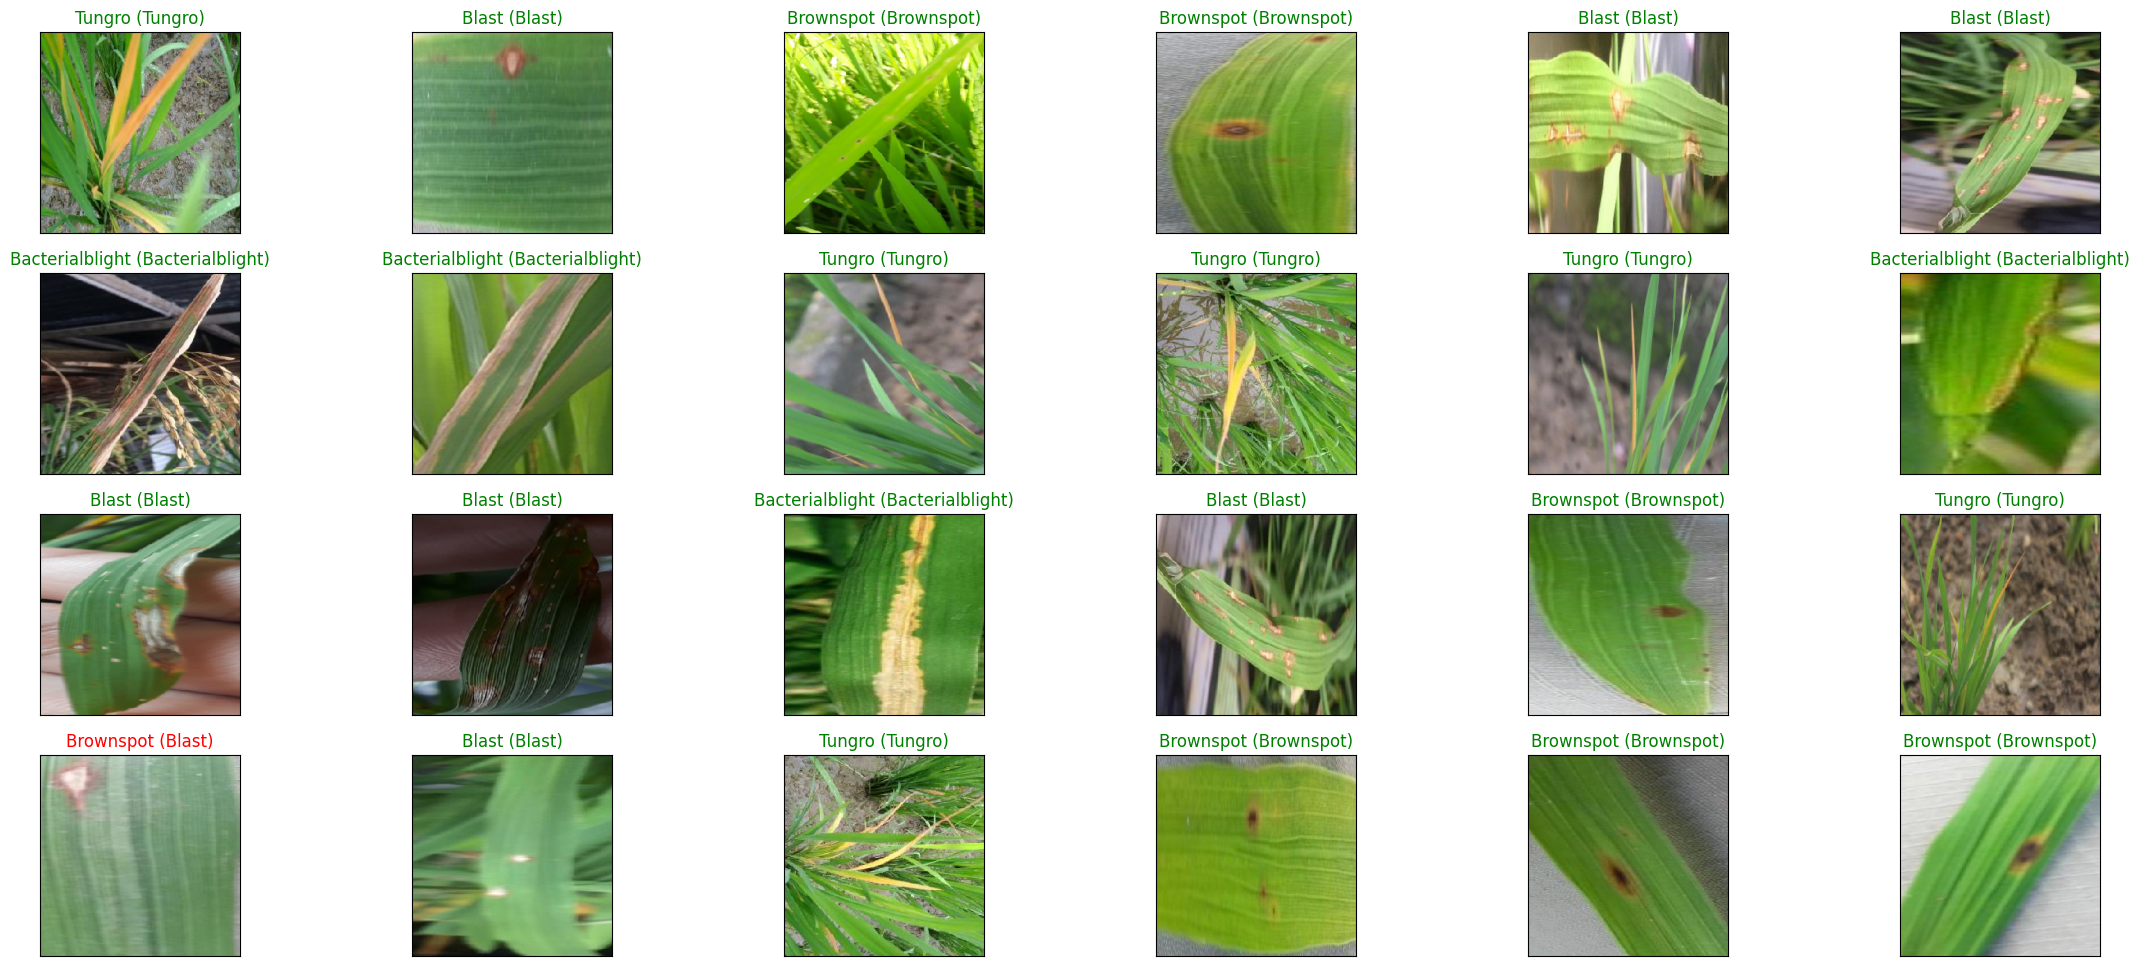

In [13]:
label_dict = {0 : 'Bacterialblight', 1 : 'Blast', 2 : 'Brownspot', 3 : 'Tungro'}

figure = plt.figure(figsize=(28, 12))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       159
           1       1.00      0.97      0.98       144
           2       0.97      1.00      0.98       160
           3       1.00      1.00      1.00       132

    accuracy                           0.99       595
   macro avg       0.99      0.99      0.99       595
weighted avg       0.99      0.99      0.99       595



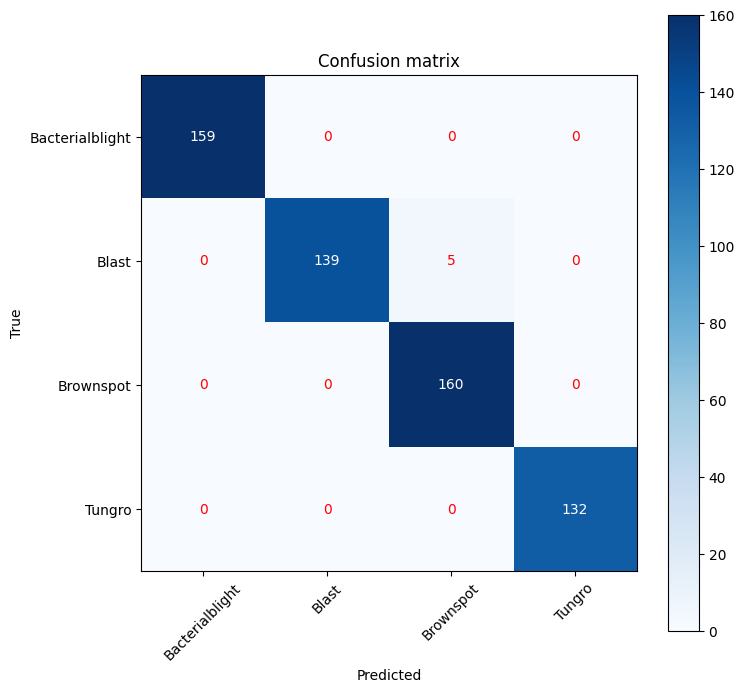

In [14]:
# Generate classification report
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred)
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

classes = list(label_dict.values())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Print the confusion matrix values on each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red' if i != j else 'white')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()